In [1]:
%matplotlib inline
import matplotlib.pyplot as plt


import os
import itertools
import json
import numpy as np
import pandas as pd
import pickle
import requests
import seaborn as sns
import collections
from collections import Counter
import scipy
import time
import copy
from collections import OrderedDict

import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition.pca import PCA


import nltk
#nltk.download('wordnet')
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
import gensim
import re
from fuzzywuzzy import process


/Users/stefgarasto/miniconda3/envs/nlp/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [2]:
from utils_nos import nesta_colours, nesta_colours_combos
print(nesta_colours, nesta_colours_combos)

[[1, 0.7215686274509804, 0.09803921568627451], [1, 0, 0.2549019607843137], [0, 0, 0], [1, 0.35294117647058826, 0], [0.6078431372549019, 0, 0.7647058823529411], [0.6470588235294118, 0.5803921568627451, 0.5098039215686274], [0.6274509803921569, 0.5686274509803921, 0.1568627450980392], [0.7686274509803922, 0.6901960784313725, 0], [0.9647058823529412, 0.49411764705882355, 0], [0.7843137254901961, 0.1568627450980392, 0.5725490196078431], [0.23529411764705882, 0.07058823529411765, 0.3215686274509804]] [[0, 1, 2, 3, 4, 5], [0, 6, 7], [1, 3, 8], [4, 9, 10], [8, 5], [1, 11]]


In [3]:
# set up plot style
print(plt.style.available)
plt.style.use(['seaborn-darkgrid','seaborn-poster','ggplot'])

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


#### TODOs for data cleaning:

1. remove square brackets
2. make everything lower case


## Overview

This notebook contains a few functions and snippets of code that are useful for analysing text. Most of the techniques used are unsupervised. Functions are defined up front and then used in sections below.

This notebook is to apply:
- Tokenizers (based on n-grams and 'as_is')
- Calculating distance
- Hierarchical clustering and plotting
- K-means clustering
- LSH

This specific instance of the notebook will be applied to the analysis of NOS


In [4]:
# flatten lists of lists
def flatten_lol(t):
    return list(itertools.chain.from_iterable(t))
flatten_lol([[1,2],[3],[4,5,6]])


[1, 2, 3, 4, 5, 6]

In [5]:
#These two functions are useful for analysing bi and tri-grams with w2v models in gensim

def convert_to_undersc(skill):
    '''
    convert spaces in skill phrases into underscores to use with trained
    w2v model.
    '''
    if len(skill.split(' ')) >1:
        new_i = '-'.join(skill.split(' '))
    else:
        new_i = skill
    return(new_i)

def convert_from_undersc(skill):
    '''
    convert underscores between terms in skill phrases back to spaces.
    '''
    if len(skill.split('_')) >1:
        new_i = ' '.join(skill.split('_'))
    else:
        new_i = skill
    return(new_i)


In [6]:
#A few functions for tyding up text
def tag_for_lemmatise(s):
    pos_to_wornet_dict = {
        'JJ': 'a',
        'JJR': 'a',
        'JJS': 'a',
        'RB': 'r',
        'RBR': 'r',
        'RBS': 'r',
        'NN': 'n',
        'NNP': 'n',
        'NNS': 'n',
        'NNPS': 'n',
        'VB': 'v',
        'VBG': 'v',
        'VBD': 'v',
        'VBN': 'v',
        'VBP': 'v',
        'VBZ': 'v',
    }
    try:
        return pos_to_wornet_dict[nltk.pos_tag([s])[0][1]]
    except:
        return 'n'
    
def lemmatise(title_terms):
    """
    Takes list as input.
    Removes suffixes if the new words exists in the nltk dictionary.
    The purpose of the function is to convert plural forms into singular.
    Allows some nouns to remain in plural form (the to_keep_asis is manually curated).
    Returns a list.
    >>> lemmatise(['teachers'])
    ['teacher']
    >>> lemmatise(['analytics'])
    ['analytics']
    """
    keep_asis = ['sales', 'years', 'goods', 'operations', 'systems',
                    'communications', 'events', 'loans', 'grounds',
                    'lettings', 'claims', 'accounts', 'relations',
                    'complaints', 'services']
    wnl = nltk.WordNetLemmatizer()
    processed_terms = [wnl.lemmatize(i) if i not in keep_asis else i for i in title_terms]
    #processed_terms = [wnl.lemmatize(i, pos = tag_for_lemmatise(i)) 
    #            if i not in keep_asis else i for i in title_terms]
    return processed_terms

def remove_digits(s):
    """
    Takes a string as input.
    Removes digits in a string.
    Returns a string.
    >>> remove_digits('2 recruitment consultants')
    ' recruitment consultants'
    """
    result = ''.join(i for i in s if not i.isdigit())
    return result

def remove_list_enumeration(s):
    '''
    This is a specific requirement of the NOS that comes from
    the presence of lists enumerated by strings like K+number
    or P+number. Therefore, after "lowerising" and removing 
    digits, I look for and remove strings like "k " and "p "
    '''
    result = re.sub('( k )+',' ',s)
    result = re.sub('( p )+', ' ', result)
    # it might not be necessary if I add 'k' and 'p' to stopwords
    return result

select_punct = set('!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~') #only removed "'"
extra_chars = set('–-•’”“µ¾âãéˆﬁ[€™¢±ï…˜')
all_select_chars = select_punct.union(extra_chars)
def replace_punctuation(s):
    """
    Takes string as input.
    Removes punctuation from a string if the character is in select_punct.
    Returns a string.
   >>> replace_punctuation('sales executives/ - london')
   'sales executives   london'
    """
    for i in set(all_select_chars): #set(select_punct):
        if i in s:
            s = s.replace(i, ' ')
    return s

def tidy_desc(desc):
    clean_data = desc.replace('\r\n', '').replace('\xa0', '')
    nodigits = remove_digits(clean_data.lower())
    nopunct = replace_punctuation(nodigits)
    #nopunct = remove_list_enumeration(nopunct)
    lemm = lemmatise(nopunct.split())
    return ' '.join(lemm)

def tokenize(text):
    """
    Takes string as input.
    Returns list of tokens. The function is used as an argument for
    TfidfVectorizer.
    >>> tokenize('some job title')
    ['some', 'job', 'title']
    """
    tokens = nltk.word_tokenize(text)
    return tokens

def tokenize_asis(some_list):
    """
    Takes list as input.
    Returns the list with elements converted to lower case. The function is 
    used as an argument for TfidfVectorizer.
    
    In [57]: tokenize(['Accounting', 'Microsoft Excel'])
    Out[57]: ['accounting', 'microsoft excel']
    """
    tokens = [elem.lower() for elem in some_list]
    return tokens

In [7]:
#This set of functions is useful for identifying terms with highest tf-idf weights 
#in a single document or set of documents

def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding 
        feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25, sparse_output = False):
    ''' Return the top n features that on average are most important 
        amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    if sparse_output:
        return scipy.sparse.csr_matrix(top_tfidf_feats(tfidf_means, features, top_n))
    else:
        return top_tfidf_feats(tfidf_means, features, top_n)

def all_mean_feats(Xtr, grp_ids=None, min_tfidf=0.1):
    ''' Return the average
        amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return tfidf_means

def get_top_words_weights(desc, feature_names, vect, n = 25):
    response = vect.transform(desc)
    words = top_mean_feats(response, feature_names, grp_ids = None, top_n = n)
    return words

def get_mean_tfidf(desc, vect):
    response = vect.transform(desc)
    tfidf_values = all_mean_feats(response, grp_ids = None)
    return tfidf_values

def get_top_words(desc, feature_names, vect, n = 25):
    response = vect.transform(desc)
    words = top_mean_feats(response, feature_names, grp_ids = None, top_n = n)
    return words['feature'].values

In [8]:
#Function to parse html

from html.parser import HTMLParser
class MyHTMLParser(HTMLParser):

#HTML Parser Methods
#Initializing lists
    lsData = list()
    
    def handle_data(self, data):
        self.lsData.append(data)
        
    def get_data(self):
        return ''.join(self.lsData)

           
def strip_tags(some_html):
    """
    Takes string as input.
    Removes html tags.
    Returns a string.
    """
    s = MyHTMLParser()
    s.lsData = list()
    s.feed(some_html)
    data = s.get_data()
    s.reset
    return data


In [9]:
def print_elapsed(t0_local, task = 'current task'):
    print('Done with {}. Elapsed time: {:4f}'.format(task,time.time()-t0_local))
    

In [10]:
qualifier = 'postjoining_final_no_dropped'
qualifier0 = 'postjoining_final_no_dropped'
pofs = 'n'


In [11]:
output_dir = '/Users/stefgarasto/Google Drive/Documents/results/NOS/nlp_analysis/'


In [12]:
lookup_dir = '/Users/stefgarasto/Google Drive/Documents/results/NOS/extracted/'


In [13]:
#Loading a pre-trained glove model into gensim
from gensim.scripts.glove2word2vec import glove2word2vec

glove_dir = '/Users/stefgarasto/Local-Data/wordvecs/glove.twitter.27B'

# to make the glove model file compatible with gensim
#for dim in ['25','50','100','200']:
##    glove_file = os.path.join(glove_dir,'glove.twitter.27B.{}d.txt'.format(dim))
#    tmp_file = os.path.join(glove_dir, 'word2vec.glove.twitter.27B.{}d.txt'.format(dim) )
#    _ = glove2word2vec(glove_file, tmp_file)

LOADGLOVE = False
if LOADGLOVE:
    # load the glove model
    model = gensim.models.KeyedVectors.load_word2vec_format\
    (os.path.join(glove_dir, 'word2vec.glove.twitter.27B.100d.txt'))
    #model = api.load("glove-wiki-gigaword-100")  # load pre-trained word-vectors from gensim-data
    #model = Word2Vec(common_texts, size=100, window=5, min_count=1, workers=4)
    #word_vectors = model.wv
print('Done')


Done


In [14]:
#Get the NOS data for approved apprenticeship standards from api
#r2 = requests.get("https://www.instituteforapprenticeships.org/api/fullstandards/")
#df_api= pd.DataFrame(r2.json())
df_nos = pd.read_pickle(lookup_dir + 'all_nos_input_for_nlp_{}.zip'.format(qualifier0))

# load the cleaned and tokenised dataset
df_nos = df_nos.join(pd.read_pickle(lookup_dir + 'all_nos_input_for_nlp_{}_pruned_{}.zip'.format(qualifier,pofs)))
print('Done')


Done


In [15]:
# manually remove "k"s and "p"s from the pruned columns
def remove_pk(x):
    return [t for t in x if t not in ['k','p']]
df_nos['pruned'] = df_nos['pruned'].map(remove_pk)

In [16]:
df_nos.sample(n=3)


Title  \
lsiyw5.4.1 v2.pdf  make sure your own actions reduce risks to hea...   
skaa334.pdf        apply accepted standards and continuously deve...   
sumise4.pdf         install fixings (integrated systems engineering)   

                                                           NOS Title  \
lsiyw5.4.1 v2.pdf  make sure your own actions reduce risks to hea...   
skaa334.pdf        apply accepted standards and continuously deve...   
sumise4.pdf         install fixings (integrated systems engineering)   

                             URN Original URN  \
lsiyw5.4.1 v2.pdf  lsiyw5.4.1 v2         hss1   
skaa334.pdf              skaa334  [SA44NA334]   
sumise4.pdf              sumise4         ise4   

                                                            Overview  \
lsiyw5.4.1 v2.pdf  [This standard addresses the health and safety...   
skaa334.pdf        [Practitioners who use their skills to assist ...   
sumise4.pdf        [This unit is for you if you prepare and insta...   

                                         Knowledge_and_understanding  \
lsiyw5.4.1 v2.pdf  [K1, K2, K3, K4, K5, K6, K7, K8, K9, K10, K11,...   
skaa334.pdf        [Apply accepted standards and continuously dev...   
sumise4.pdf        [K1, the purpose of a risk assessment and meth...   

                                                Performance_criteria  \
lsiyw5.4.1 v2.pdf  [Identify the hazards and evaluate the risks i...   
skaa334.pdf        [Apply accepted standards and continuously dev...   
sumise4.pdf        [P1, you confirm with the responsible person t...   

                                                         Scope_range  \
lsiyw5.4.1 v2.pdf                                                NaN   
skaa334.pdf        [Apply accepted standards and continuously dev...   
sumise4.pdf                                                      NaN   

                                                            Glossary  \
lsiyw5.4.1 v2.pdf                                                NaN   
skaa334.pdf                                                      NaN   
sumise4.pdf        [Access Equipment, These include: stepladders,...   

                  Behaviours  ... notes  empty extra_meta_info  \
lsiyw5.4.1 v2.pdf        NaN  ...   NaN  False             NaN   
skaa334.pdf              NaN  ...   NaN  False             NaN   
sumise4.pdf              NaN  ...   NaN  False             NaN   

                              Created            Modified  Item Type  \
lsiyw5.4.1 v2.pdf 2014-03-31 17:44:09 2018-08-07 13:36:11       item   
skaa334.pdf                       NaT                 NaT        NaN   
sumise4.pdf       2014-03-31 18:09:25 2018-08-07 15:46:12       item   

                               Path  \
lsiyw5.4.1 v2.pdf  publishednos-old   
skaa334.pdf                     NaN   
sumise4.pdf        publishednos-old   

                                                              pruned  \
lsiyw5.4.1 v2.pdf  [action, risk, health, safety, hazard, risk, r...   
skaa334.pdf        [standard, practice, injury, sport, recreation...   
sumise4.pdf        [install, fixing, engineering, purpose, risk, ...   

                                                     clean_full_text  \
lsiyw5.4.1 v2.pdf  make sure your own action reduce risk to healt...   
skaa334.pdf        apply accepted standard and continuously devel...   
sumise4.pdf        install fixing integrated systems engineering ...   

                                                       tagged_tokens  
lsiyw5.4.1 v2.pdf  [(make, VB), (sure, JJ), (your, PRP$), (own, J...  
skaa334.pdf        [(apply, RB), (accepted, JJ), (standard, NN), ...  
sumise4.pdf        [(install, NN), (fixing, NN), (integrated, JJ)...  

[3 rows x 43 columns]

In [17]:
# Load stopwords
with open(lookup_dir + 'stopwords_for_nos_{}_{}.pickle'.format(qualifier,pofs),'rb') as f:
    stopwords0, no_idea_why_here_stopwords, more_stopwords = pickle.load(f)
stopwords = stopwords0 + no_idea_why_here_stopwords 
stopwords += tuple(['¤', '¨', 'μ', 'บ', 'ย', 'ᶟ', '‰', '©', 'ƒ', '°', '„'])
stopwords0 += tuple(['¤', '¨', 'μ', 'บ', 'ย', 'ᶟ', '‰', '©', 'ƒ', '°', '„'])


## Get raw data and tokenize

Let's first load the NOS text data, together with the clean text and the tokens with only selected parts of speech.

Then, there are several strategies we could use to convert the corpus into a document-term matrix. Some of the most common ones are using:
- Counts
- Term frequency - inverse document frequency metric (tf-idf)

## Choosing parameters for features extraction

ngrams : uni/bi/tri

tfidf thresholds: min and max percentage

which parts of speech were selected before

whether we are working at the level of suites or of invidual NOS, and how we aggregate NOS to form the suit level


In [18]:
# First, create your TFidfVectorizer model. This doesn't depend on whether it's used on suites or NOS. However,
# it does require that the docs collection is already given as a collection of tokens (tokenizer=tokenize_asis)

#Since we now have not just long strings in our documents, but lists of terms, we will use a different tokenizer
def define_tfidf(params, stopwords):
    if params['ngrams'] == 'bi':
        tfidf = TfidfVectorizer(tokenizer=tokenize_asis,
                                lowercase = False,
                                stop_words=stopwords,
                                ngram_range=(1,2), 
                                max_df = params['tfidf_max'], 
                                min_df = params['tfidf_min'])
    elif params['ngrams'] == 'tri':
        tfidf = TfidfVectorizer(tokenizer=tokenize_asis,
                                lowercase = False,
                                stop_words=stopwords,
                                ngram_range=(1,3), 
                                max_df = params['tfidf_max'], 
                                min_df = params['tfidf_min'])
    else:
        # unigrams is the default
        tfidf = TfidfVectorizer(tokenizer=tokenize_asis,
                                lowercase = False,
                                stop_words=stopwords,
                                max_df = params['tfidf_max'], 
                                min_df = params['tfidf_min'])
    return tfidf


In [19]:
# now, collect the text to transform
def combine_nos_text(df_nos):
    all_joint_tokens = []
    # group by suites and concatenate all docs in it
    row_names = []
    for name, group in df_nos.groupby('One_suite'):
        row_names.append(name)
        joint_tokens = []
        for idoc in group['pruned'].index:
            joint_tokens += group['pruned'].loc[idoc]
        all_joint_tokens.append(joint_tokens)
    # return a dataframe
    return pd.DataFrame({'tokens': all_joint_tokens}, index = row_names)

def get_tfidf_matrix(params, df_nos, tfidf):
    # Note: this can simply be used to get the tfidf transform, by setting bywhich=docs and any mode
    t0 = time.time()
    # first, get the dataframe of tokens
    if params['bywhich'] == 'docs':
        textfortoken = df_nos['pruned']
        
    elif params['bywhich'] == 'suites':
        if params['mode'] == 'meantfidf':
            textfortoken = df_nos['pruned']
                
        elif params['mode'] == 'combinedtfidf':
            # note that this is the only case where the tfidf min and max are computed considering the number of 
            # suites as the number of elements in the collection.
            # TODO: allow for the alternative case, where the transform is computed on individual NOS and then 
            # applied to the joint tokens
            textfortoken = combine_nos_text(df_nos)['tokens']
    
    # apply tfidf transform to the tokenised text
    tfidfm = tfidf.fit_transform(textfortoken)
    
    # if the average is needed, compute it and overwrite the matrix. Note that the step above is still needed to
    # initialise the tfidf transform with the proper features and stopwords
    if (params['bywhich'] == 'suites') and (params['mode'] =='meantfidf'):
        row_names = df_nos['One_suite'].value_counts().index.values
        tfidfm = scipy.sparse.lil_matrix(np.zeros((len(row_names),len(feature_names)), dtype = np.float32))
        for name, group in df_nos.groupby('One_suite'):
            tmp = get_mean_tfidf(group['pruned'], tfidf)
            tfidfm[igroup] = tmp

    feature_names = tfidf.get_feature_names()
    print_elapsed(t0, 'computing the feature vector')
    return tfidfm, feature_names, textfortoken


## Relationships between standards

In [20]:
from scipy.cluster.hierarchy import ward, dendrogram
from scipy.spatial import distance
from scipy.cluster.hierarchy import cophenet
from scipy.cluster.hierarchy import fcluster 


In [ ]:
# if we only want to cluster one suite
#steel_construction = df_nos[df_nos['One_suite'] == 'steelfix construction']


In [21]:
sns.set_style("whitegrid")


In [22]:
SAVEHC = False


### Load the file with the list of super-suites and match the suites listed inside

In [23]:
super_suites_files=  '/Users/stefgarasto/Google Drive/Documents/data/NOS_meta_data/NOS_Suite_Priority.xlsx'
super_suites_names = ['Engineering','Management','FinancialServices','Construction']
all_super_suites = {}
for which_super_suite in super_suites_names:
    all_super_suites[which_super_suite] = pd.read_excel(super_suites_files, sheet_name = which_super_suite)
    all_super_suites[which_super_suite]['NOS Suite name'] = all_super_suites[which_super_suite]['NOS Suite name'].map(
        lambda x: x.replace('(','').replace('(','').replace('&','and').strip().lower())


In [24]:
standard_labels = list(df_nos.groupby('One_suite').groups.keys())
all_matches = {}
all_match_names = {}
#match_name = []
for which_super_suite in super_suites_names:
    all_matches[which_super_suite] = []
    for suite in all_super_suites[which_super_suite]['NOS Suite name'].values:
        # do manually some selected suites
        if 'insurance claims' in suite:
            tmp = standard_labels.index('general insurance')
            all_matches[which_super_suite].append(tmp)
            continue
        # for the "management and leadership marketing 2013" both marketing and marketing 2013 would fit,
        # but I'm only taking the latter
        # find a fuzzy match between 
        out = process.extract(suite, standard_labels, limit=3)
        if len(out) and out[0][1]>89:
            # note: most of them are above 96% similarity (only one is 90%)
            tmp = standard_labels.index(out[0][0])
            #print(suite, out[0])
            if tmp not in all_matches[which_super_suite]:
                all_matches[which_super_suite].append(tmp)
            else:
                if suite == 'installing domestic fascia, soffit, and bargeboards':
                    # this suite is kind of a duplicate - I aggregated it in my suites list
                    continue
                tmp = standard_labels.index(out[2][0])
                all_matches[which_super_suite].append(tmp)
                print(out[0][0],',',out[1][0],',',out[2][0],',',suite)
        else:
            print(suite, ' not found')
            print(out)
            print('\n')
    print(len(all_matches[which_super_suite]),len(all_super_suites[which_super_suite]))
    all_match_names[which_super_suite] = [standard_labels[t] for t in all_matches[which_super_suite]]
    #print(super_suites['NOS Suite name'].values)


83 83
management and leadership , marketing , marketing 2013 , management and leadership marketing 2013)
59 59
29 29
75 76


In [56]:
standard_labels

['2010 incremental change to the nos in interpreting',
 'abnormal load escorting',
 'access operations and rigging broadcast, film and video',
 'accessing operations and rigging construction',
 'accident repair body',
 'accident repair joining',
 'accident repair mechanical, electrical and trim',
 'accident repair paint',
 'accident repair smart cosmetic',
 'accident repair smart pdr',
 'accountancy and finance',
 'achieving excellence in sports performance',
 'achieving excellence in sports performance inc change june 2007',
 'achieving food manufacturing excellence',
 'activity leadership',
 'activity leadership l2 2002',
 'addressing and responding to honour based violence',
 'addressing modern slavery',
 'addressing stalking',
 'administration for mortgage and or financial planning intermediaries',
 'administration of local revenues and benefits',
 'advanced wood occupations',
 'advertising sales',
 'advice and guidance',
 'aeronautical engineering suite 2',
 'aeronautical engineer

In [141]:
# change the parameters if needed
params = {}
params['ngrams'] = 'uni'
params['pofs'] = 'n'
params['tfidf_min'] = 3
params['tfidf_max'] = 0.4

params['bywhich'] = 'suites' #'docs' #'suites'
params['mode'] = 'combinedtfidf' #'tfidf' #'meantfidf' #'combinedtfidf' #'meantfidf'

# get the transform tfidf
tfidf = define_tfidf(params, stopwords0)

# get the matrix again (even though if the parameters stay the same, this one is the same still)
# get the features
tfidfm, feature_names, textfortoken = get_tfidf_matrix(params, df_nos, tfidf)

# get labels
if params['bywhich'] == 'suites':
    standard_labels = list(df_nos.groupby('One_suite').groups.keys())
else:
    standard_labels = list(df_nos['Title'].values)
    

Done with computing the feature vector. Elapsed time: 3.459575


In [142]:
standard_labels = list(df_nos.groupby('One_suite').groups.keys())
standard_labels2 = textfortoken.index.values
s_idx = standard_labels.index('business continuity management 2013')
TF= tfidfm[s_idx,:].T.todense()
for ix,t in enumerate(feature_names):
    if TF[ix]>0.05:
        print(t)
#for it in range(len(standard_labels)):
#    print(standard_labels[it],',',standard_labels2[it])

bcm
bia
chain
continuity
incident
maker
ra


In [143]:
feature_names.index('engineer'), len(feature_names), tfidfm.shape

(5200, 17100, (968, 17100))

In [144]:
collections.Counter(textfortoken.loc['animal care v2'])

Counter({'prepare': 1,
         'animal': 51,
         'production': 6,
         'environment': 6,
         'plan': 13,
         'transportation': 16,
         'transfer': 9,
         'containment': 2,
         'restraint': 3,
         'accommodation': 16,
         'transport': 1,
         'relation': 1,
         'health': 5,
         'safety': 7,
         'security': 1,
         'circumstance': 1,
         'travel': 2,
         'permit': 4,
         'feeding': 4,
         'exercise': 4,
         'requirement': 7,
         'onto': 1,
         'provision': 2,
         'welfare': 6,
         'density': 1,
         'number': 2,
         'specie': 1,
         'length': 1,
         'journey': 2,
         'arrangement': 5,
         'order': 3,
         'film': 9,
         'location': 15,
         'factor': 2,
         'stress': 1,
         'way': 3,
         'type': 3,
         'need': 4,
         'builder': 1,
         'measure': 2,
         'care': 12,
         'principle': 1,
         'ou

In [145]:
#We calculate cosine distance between tf-idf vectors of the documents

def do_hierarch_clustering(tfidfm, DOPLOTS = True):
    t0 = time.time()
    N2 = 11914
    N = 400 #400*400 = 160000 distance calls per second. For N=21500 -- > 462250000 calls --> 2900*160000 calls 
    # --> I'm guessing 2900 seconds = 48 minutes (I think it's likely to be more actually)
    # 4000*4000 takes approximately 110 seconds. It's double for the cophenet. So, for N=22500, the three functions 
    # together will take approx 4 hours (I'll do it tonight)

    try:
        distances = distance.pdist(tfidfm.todense(), metric = 'cosine') # + np.random.randn(N,N2), metric = 'cosine')
        sparse_flag = True
    except:
        distances = distance.pdist(tfidfm, metric = 'cosine')
        sparse_flag = False
    print_elapsed(t0, 'calculating cosine distances of tfidf vectors')

    #We then build linkage matrix using the distances and specifying the method. For euclidean distances typically
    # 'Ward' produces best results. For cosine we can only use 'average' and 'single'.
    linkage_matrix = scipy.cluster.hierarchy.linkage(distances,
                                                     method = 'average',
                                                     metric = 'cosine')
    print_elapsed(t0, 'hierarchical clustering of cosine distances')
    #We can test how well the groupings reflect actual distances. If c > 0.75 this is considered to be sufficiently
    #good representation
    if sparse_flag:
        c, coph_dists = cophenet(linkage_matrix, 
                             distance.pdist(tfidfm.todense(), metric = 'cosine'))
    else:
        c, coph_dists = cophenet(linkage_matrix, 
                             distance.pdist(tfidfm, metric = 'cosine'))

    print_elapsed(t0, 'computing the cophenetic correlation')

    if DOPLOTS:
        fig, ax =plt.subplots(figsize = (5,5))
        ax.matshow(scipy.spatial.distance.squareform(distances))
        plt.title('cosine distances between suites')

        fig, ax = plt.subplots(figsize = (5,5))
        tmp = ax.matshow(scipy.spatial.distance.squareform(coph_dists))
    print('The cophenetic coefficient is {:.4f}'.format(c))
    return distances, linkage_matrix, c, coph_dists



Done with calculating cosine distances of tfidf vectors. Elapsed time: 9.430732
Done with hierarchical clustering of cosine distances. Elapsed time: 9.446336
Done with computing the cophenetic correlation. Elapsed time: 18.970850
The cophenetic coefficient is 0.7760


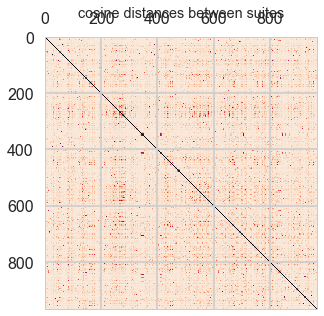

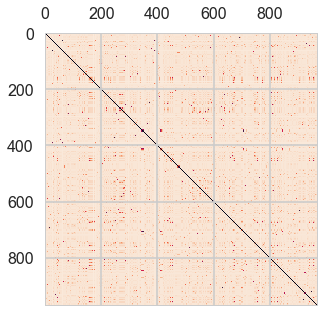

In [146]:
# perform hierarchical clustering
distances, linkage_matrix, c, _ = do_hierarch_clustering(tfidfm)


In [147]:
distances.shape

(468028,)

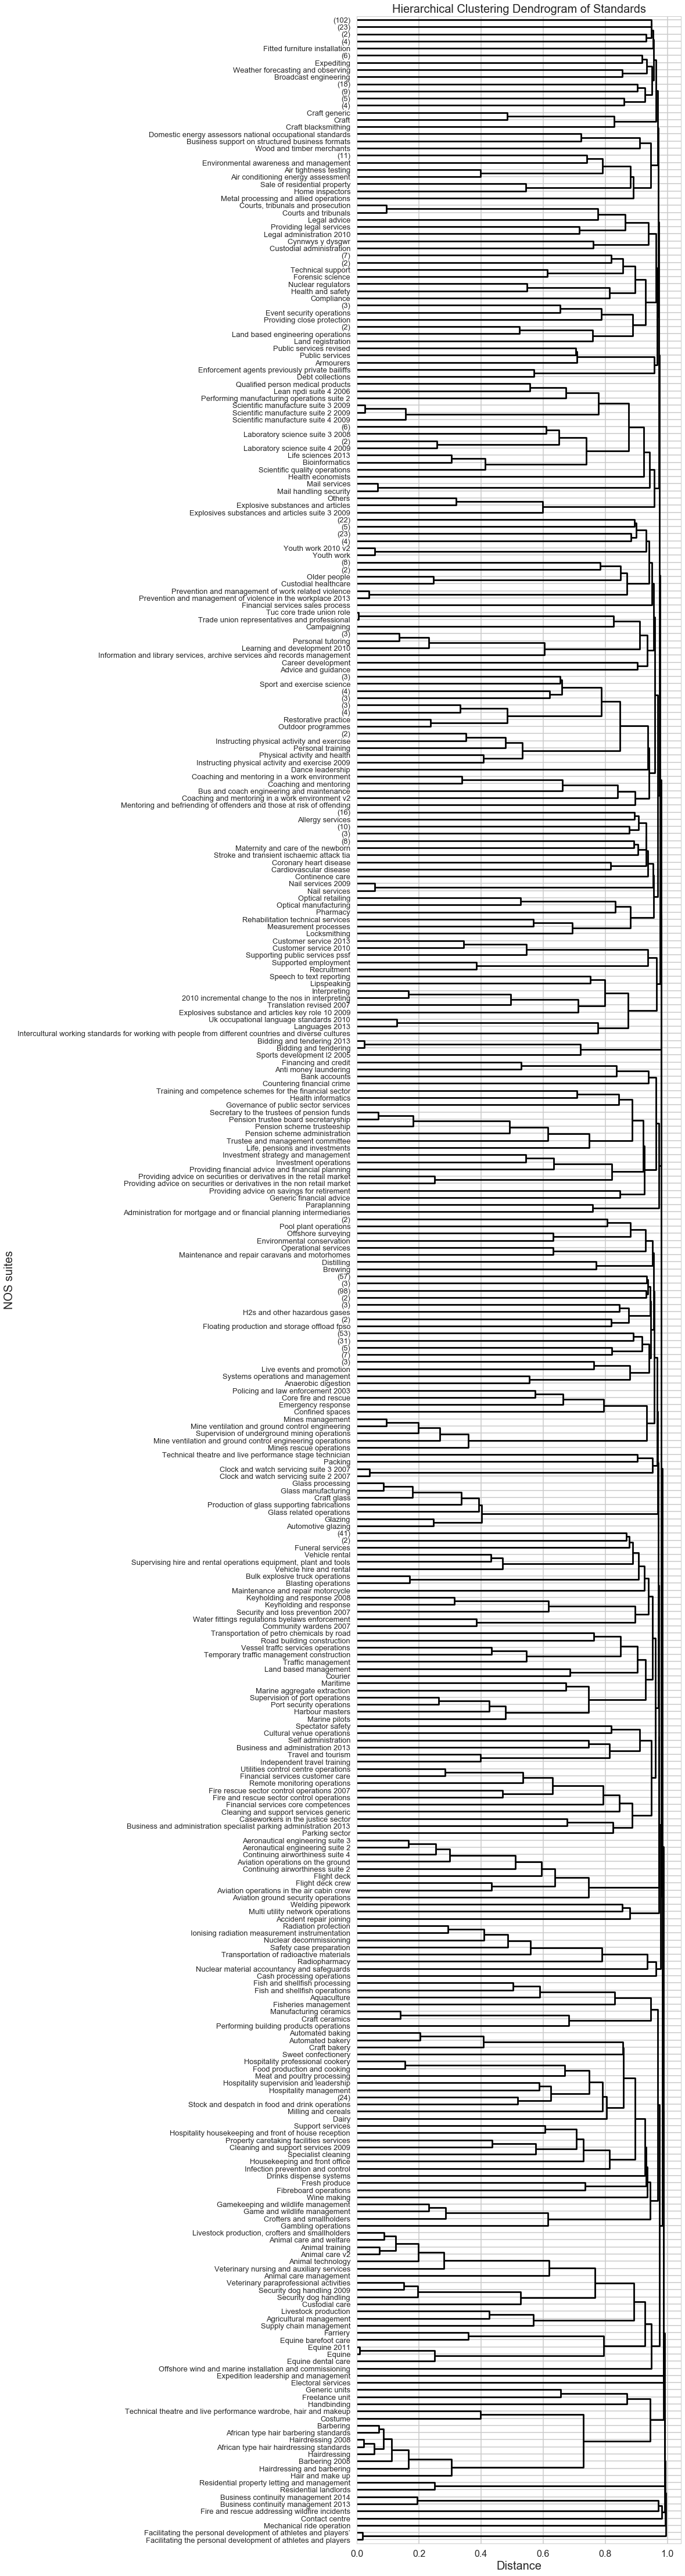

In [148]:
#Plot the dendrogram
fig, ax = plt.subplots(figsize=(10, 80)) # set size
ax = dendrogram(linkage_matrix, 
                labels = [t.capitalize() for t in standard_labels], 
                orientation = 'right', 
                leaf_font_size=6,
               color_threshold = 0,
               truncate_mode = 'level', p =20,
               above_threshold_color = 'k');

plt.tick_params(axis= 'y',
                labelsize = 13)
plt.title('Hierarchical Clustering Dendrogram of Standards', fontsize = 20)
plt.xlabel('Distance', fontsize = 20)
plt.ylabel('NOS suites',fontsize = 20)
if SAVEHC and False:
    plt.savefig(os.path.join(output_dir, 'nos_aggregated_dendrogram_{}_{}_{}.png'.format(qualifier,params['bywhich'],
                                                    params['mode'])), bbox_inches = "tight")   
    

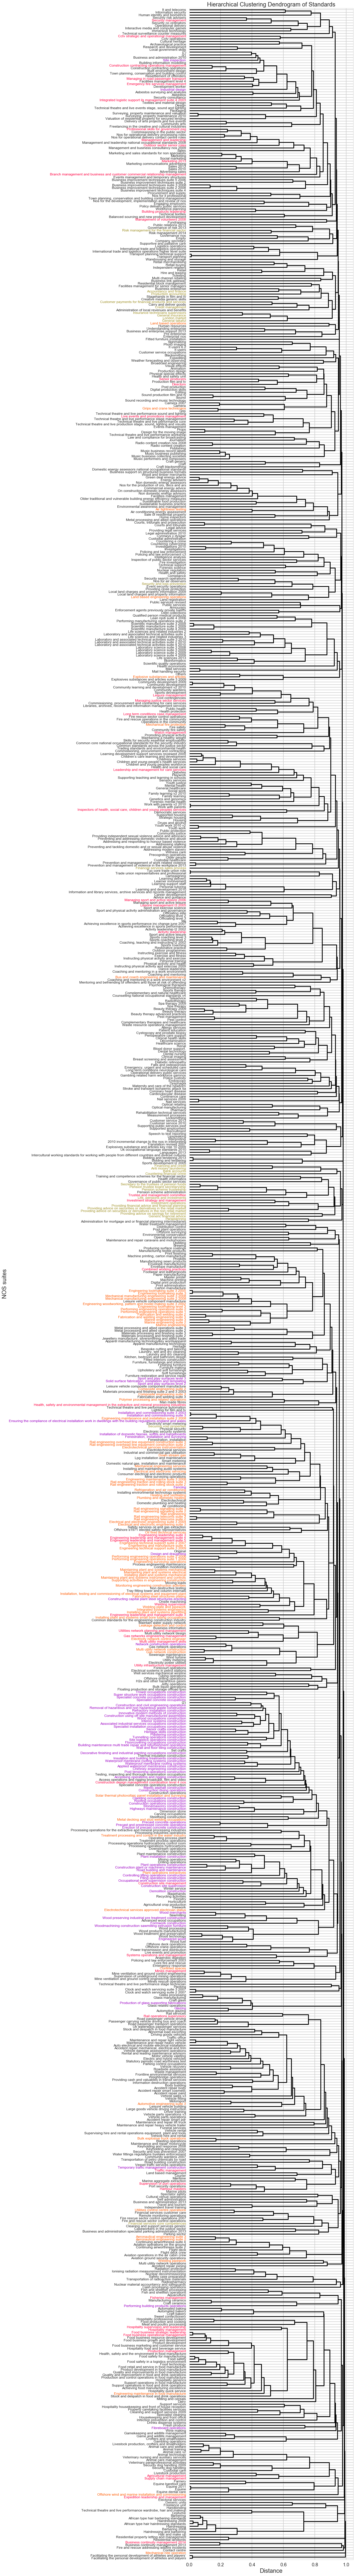

In [149]:
#Re-plot the dendrogram
fig, ax = plt.subplots(figsize=(10, 160)) # set size
ax = dendrogram(linkage_matrix, 
                labels = [t.capitalize() for t in standard_labels], 
                orientation = 'right', 
                leaf_font_size=6,
               color_threshold = 0,
               truncate_mode = 'level', p =43,
               above_threshold_color = 'k');

plt.tick_params(axis= 'y',
                labelsize = 12)
plt.title('Hierarchical Clustering Dendrogram of Standards', fontsize = 20)
plt.xlabel('Distance', fontsize = 20)
plt.ylabel('NOS suites',fontsize = 20)
T = plt.yticks()
super_suites_colours = {'Management': nesta_colours[1], 'Engineering': nesta_colours[3],
                        'FinancialServices':nesta_colours[6], 'Construction': nesta_colours[4]}
for t in T[1]:
    for which_super_suite in super_suites_names:
        if t.get_text().lower() in all_match_names[which_super_suite]:
            #print(t,',',which_super_suite)
            #plt.text(t,'r')
            t.set_color(super_suites_colours[which_super_suite])
            break

if SAVEHC and False:
    plt.savefig(os.path.join(output_dir, 'nos_aggregated_dendrogram_{}_{}_{}.pdf'.format(qualifier,params['bywhich'],
                                                    params['mode'])), bbox_inches = "tight")   
    

In [150]:
for t in all_matches['Engineering']:
    TF= tfidfm[t,:].T.todense()
    print(standard_labels[t])
    for ix,fn in enumerate(feature_names):
        if TF[ix]>0.08:
            print(fn)
    print('\n')

aeronautical engineering suite 3
aircraft
aviation
engine
fastener
flight
installation


marine engineering suite 3
assembly
boat
cable
circuit
compartment
defect
device
directive
fastener
fault
fire
installation
machine
marine
overhaul
overhauling
pipework
precaution
surface
vessel
welding
wire
yacht


explosive substances and articles
article
blast
munition
ordnance
organization
relevance
someone
trial
vehicle


rail engineering
asset
bearer
book
coshh
dc
diagram
disease
electrification
element
engineering
fault
haswa
infrastructure
installation
law
occurrence
ohle
plant
ppe
rail
railway
renewal
restriction
riddor
rule
section
telecom
track
traction
vicinity


automotive engineering suite 3
assembly
cable
device
engine
fastener
installation
leisure
loom
motorsport
moulding
refitting
resin
sub
vehicle


marine engineering suite 2
assembly
boat
cable
coating
deck
device
directive
fastener
gas
installation
load
machine
marine
paint
pipe
pipework
precaution
rope
sheet
surface
vessel
weld

transmission
tunnel
variation
vessel
workshop


mechanical fire protection
certification
fire
installation
mist
quotation
sprinkler


grips and crane technicians
arm
cable
camera
crane
grip
jib
mount
obstruction
rig
sand
shot
strop
surface
teamwork
track
vehicle
weight


engineering toolmaking level 3
assembly
defect
die
dy
guard
handover
injection
machine
machining
mechanism
mould
press
try


plant operations extractives
avoid
dispose
interpretation
load
occupation
official
operate
organise
plant
prevent
protect
sequence
space
status


utilities control centre operations
call
caller
email
field
list
mail
message
reply
search
software
telephone
utility
worker


air tightness testing
air
building
calculation
calibration
envelope
fan
permeability
pressure
testing
tightness


rail engineering telecoms suite 2
assist
bearer
cctv
circuit
connection
controller
coshh
disconnection
doo
engineering
gsm
haswa
installation
isolation
leader
ohle
opo
planner
possession
pt
removal
replacement
riddor

In [151]:
# extract the super-suites subset from the cosine matrix and print average similarity matrix
average_super_similarity = {}
tfidf_super = {}
for which_super_suite in super_suites_names:
    tfidf_super[which_super_suite] = tfidfm[all_matches[which_super_suite],:]

for which_super_suite in super_suites_names:
    average_super_similarity[which_super_suite] = {}
    for which_super_suite2 in super_suites_names:
        A = distance.cdist(tfidf_super[which_super_suite].todense(),
                           tfidf_super[which_super_suite2].todense(), metric = 'cosine')
        N = A.shape
        if which_super_suite == which_super_suite2:
            B = A[np.triu_indices(N[0],1)]
        else:
            B = A#[np.triu_indices(N[0],m=N[1])]
        average_super_similarity[which_super_suite][which_super_suite2] = (np.around(np.mean(B),2),
                                                                           np.around(np.median(B),2),
                                                                           np.around(np.std(B),2))
print('Done')


Done


(75, 17100)
0.5552958881849039 0.5552958881849042 1.0 1.0000000000000004
wood occupations construction
['accident', 'avoidance', 'belonging', 'contract', 'cosvr', 'curvature', 'door', 'exhaust', 'extinguisher', 'fire', 'floor', 'foam', 'frame', 'height', 'install', 'interpretation', 'ironmongery', 'joinery', 'lev', 'lifting', 'mark', 'metal', 'occupation', 'operative', 'powder', 'respiratory', 'roof', 'sash', 'space', 'staircase', 'timber', 'ventilation', 'wall', 'wooden']
specialist installation occupations construction
['accident', 'belonging', 'blind', 'contract', 'cosvr', 'deadline', 'demonstration', 'display', 'door', 'enclosure', 'fire', 'gate', 'height', 'install', 'installation', 'interpretation', 'lifting', 'machinery', 'movement', 'occupation', 'operative', 'pallet', 'ppe', 'screen', 'shutter', 'space', 'spillage', 'weather']
0.6895045514446783


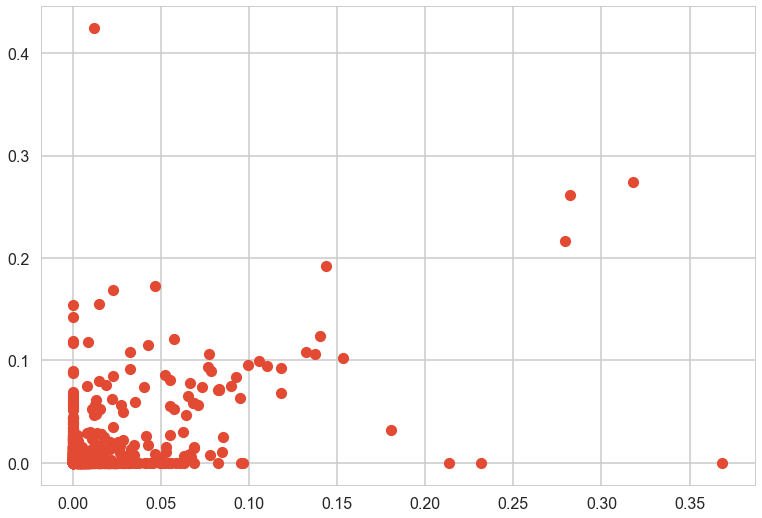

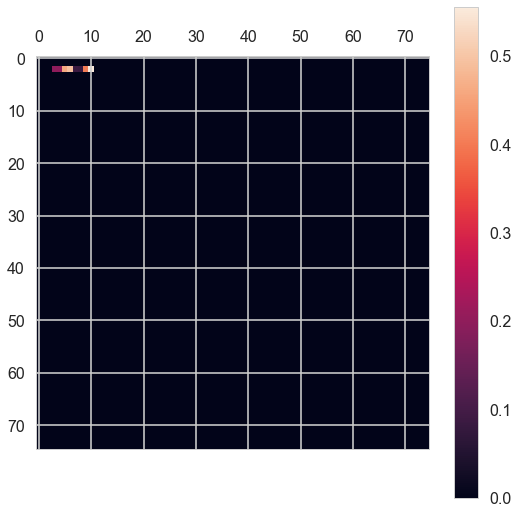

In [152]:
s1='Construction'
A = tfidfm[all_matches[s1],:].todense()
print(A.shape)
B = np.zeros((A.shape[0],A.shape[0]))
Bl = []
for ia in range(2,A.shape[0]):
    a1 = A[ia].T
    a1 = np.asarray(a1)
    for ia2 in range(ia+1,A.shape[0]):
        a2 = A[ia2].T
        den1 = np.sqrt((np.asarray(a1.T)*np.asarray(a1.T)).sum())
        den2 = np.sqrt((np.asarray(a2.T)*np.asarray(a2.T)).sum())
        B[ia,ia2] = ((np.asarray(a1.T)*np.asarray(a2.T)).sum())/den1/den2
        num = (np.asarray(a1.T)*np.asarray(a2.T)).sum()
        Bl.append(num/den1/den2)
        if ia2==10:
            plt.plot(a1,a2,'o')
            #plt.plot(a2)
            print(Bl[-1],num,den1,den2)
            print(standard_labels[all_matches[s1][ia2]])
            print([t for ix,t in enumerate(feature_names) if a2[ix]>.08])
            print(standard_labels[all_matches[s1][ia]])
            print([t for ix,t in enumerate(feature_names) if a1[ix]>.08])
            break
    break
plt.matshow(B)
plt.colorbar()
print(1-np.mean(Bl))

In [154]:
print(average_super_similarity)
pd.DataFrame.from_dict(average_super_similarity)

{'Engineering': {'Engineering': (0.88, 0.92, 0.13), 'Management': (0.96, 0.98, 0.08), 'FinancialServices': (0.99, 0.99, 0.03), 'Construction': (0.93, 0.95, 0.07)}, 'Management': {'Engineering': (0.96, 0.98, 0.08), 'Management': (0.93, 0.97, 0.11), 'FinancialServices': (0.97, 0.98, 0.04), 'Construction': (0.97, 0.98, 0.06)}, 'FinancialServices': {'Engineering': (0.99, 0.99, 0.03), 'Management': (0.97, 0.98, 0.04), 'FinancialServices': (0.92, 0.96, 0.13), 'Construction': (0.99, 1.0, 0.03)}, 'Construction': {'Engineering': (0.93, 0.95, 0.07), 'Management': (0.97, 0.98, 0.06), 'FinancialServices': (0.99, 1.0, 0.03), 'Construction': (0.82, 0.88, 0.17)}}


Engineering          Management   FinancialServices  \
Construction       (0.93, 0.95, 0.07)  (0.97, 0.98, 0.06)   (0.99, 1.0, 0.03)   
Engineering        (0.88, 0.92, 0.13)  (0.96, 0.98, 0.08)  (0.99, 0.99, 0.03)   
FinancialServices  (0.99, 0.99, 0.03)  (0.97, 0.98, 0.04)  (0.92, 0.96, 0.13)   
Management         (0.96, 0.98, 0.08)  (0.93, 0.97, 0.11)  (0.97, 0.98, 0.04)   

                         Construction  
Construction       (0.82, 0.88, 0.17)  
Engineering        (0.93, 0.95, 0.07)  
FinancialServices   (0.99, 1.0, 0.03)  
Management         (0.97, 0.98, 0.06)

If we wanted to cut the dendrogram at a certain distance threshold, we would use fcluster as shown below

In [ ]:

labels_h = fcluster(linkage_matrix, 0.8, criterion='distance')

if params['bywhich']== 'suites':
    short_df = pd.DataFrame(standard_labels)
    short_df.columns = ['Suite_names']
else:
    short_df = df_nos[['Title', 'One_suite']].iloc

short_df['hierarchical'] = labels_h

n_clusters = len(collections.Counter(labels_h))
print(n_clusters)


In [ ]:
# print the result of the cut dendrogram
hierarchical_dict= {}
for ic in range(1,n_clusters+1):
    hierarchical_dict['{}'.format(ic)] = short_df['Suite_names'][short_df['hierarchical']==ic].values
if SAVEHC:
    pd.DataFrame.from_dict(hierarchical_dict, orient = 'index').to_csv(output_dir +
                            '/Hierarchical_results_{}_{}_{}.csv'.format(qualifier,params['bywhich'],params['mode']))
    

In [ ]:
# Perform hierarchical clustering only on the suites in one super-suite (e.g. Management)
which_super_suite = 'Management'
match_name = all_match_names[which_super_suite]
match = all_matches[which_super_suite]


In [ ]:
# perform hierarchical clustering on the suites belonging to the super suite alone
distances_super, linkage_matrix_super, c_super, c_dist_super = do_hierarch_clustering(tfidfm[match,:], 
                                                                                      DOPLOTS = False)

#Plot the dendrogram again for this super-suite
standard_labels_super = [standard_labels[t].capitalize() for t in match]

fig, ax = plt.subplots(figsize=(10, 20)) # set size
ax = dendrogram(linkage_matrix_super, 
                labels = standard_labels_super, 
                orientation = 'right', 
                leaf_font_size=6,
               color_threshold = 0,
               truncate_mode = 'level', p =40,
               above_threshold_color = 'k');

plt.tick_params(axis= 'y',
                labelsize = 14)
plt.title('Hierarchical Clustering Dendrogram of NOS (in super-suite {})'.format(which_super_suite), fontsize = 18)
plt.xlabel('Distance', fontsize = 18)
plt.ylabel('NOS suites',fontsize = 18)
if SAVEHC:
    plt.savefig(os.path.join(output_dir, 'nos_dendrogram_{}_{}_{}_{}.png'.format(which_super_suite,
                                            qualifier,params['bywhich'],params['mode'])), bbox_inches = "tight")     
    

In [ ]:
labels_h = fcluster(linkage_matrix_super, 0.9, criterion='distance')

if params['bywhich']== 'suites':
    short_df = pd.DataFrame(standard_labels_super)
    short_df.columns = ['Suite_names']
else:
    short_df = df_nos[['Title', 'One_suite']].iloc

short_df['hierarchical'] = labels_h

n_clusters = len(collections.Counter(labels_h))
print(n_clusters,len(labels_h))


# Collect and save data for graph visualisation

In [ ]:
def get_one_soc(x):
    if isinstance(x,list):
        try:
            return x[0]
        except:
            return np.nan
    else:
        return x
    
def get_one_occupation(x):
    if isinstance(x,list):
        y= ''.join(x)
    else:
        y= x
    if isinstance(y,str):
        return y.split(';')
    else:
        return y
    

In [ ]:
# collect metadata for all suites in the super-suite
metadata = {}
nb_of_nos = []
datadriven_keywords = []
expert_keywords = []
top_developed = []
top_originating = []
top_approved_year = []
top_SOC = []
top_occupation = []
# group by suite
groups = df_nos.groupby('One_suite')
# cycle through suites
for suite in match_name:
    group = groups.get_group(suite)
    # how many nos in this suite
    nb_of_nos.append(len(group))
    # suite keywords (identified before)
    datadriven_keywords.append(top_terms_dict[name + ' (top features)'])
    # list of actual keywords (ordered by popularity)
    expert_keywords.append(top_terms_dict[name + ' (keywords)'])
    # most common developing and originating organisation
    top_originating.append(group['Originating_organisation'].value_counts().index[0])
    top_developed.append(group['Developed By'].value_counts().index[0])
    # most common year approved
    top_approved_year.append(group['Date_approved_year'].value_counts().index[0])
    # top SOC code (in order)
    try:
        top_SOC.append(group['Clean SOC Code'].map(get_one_soc).value_counts().index[0])
    except:
        top_SOC.append(np.nan)
    # most common occupations
    tmp = []
    for t in group['Occupations'].map(get_one_occupation):
        tmp += t
    top_occupation.append(pd.DataFrame(tmp)[0].value_counts().index[0].strip())
    if not top_occupation[-1]:
        top_occupation[-1] = np.nan

# now make dictionary
metadata['nb_of_nos'] = nb_of_nos
metadata['datadriven_keywords'] = datadriven_keywords
metadata['expert_keywords'] = expert_keywords
metadata['top_originating_organisation'] = top_originating
metadata['top_developed_by'] = top_developed
metadata['top_approved_year'] = top_approved_year
metadata['top_soc'] = top_SOC
metadata['top_occupation'] = top_occupation
#metadata['suite_name'] = match_name
# change to dataframe
df_metadata = pd.DataFrame.from_dict(metadata)
#df_metadata = df_metadata.set_index('suite_name')


In [ ]:
df_management_cluster = df_metadata.join(short_df).set_index('Suite_names')#.drop('Suite_names')
print(df_management_cluster.head(n=3))
df_management_cluster.isnull().sum()


In [ ]:
SAVEDATAHC = False
if SAVEDATAHC:
    with open(os.path.join(output_dir, 'for_graph_visualisation/data_from_management_clustering.pickle'), 'wb') as f:
        pickle.dump((df_management_cluster, distances_super, linkage_matrix_super, c_super, c_dist_super), f)
        

### For each suite in the management super-suite, collect the same information as for the whole management supersuite and save it

In [ ]:
params2 = {}
params2['ngrams'] = 'uni'
params2['pofs'] = 'n'
params2['tfidf_min'] = 3
params2['tfidf_max'] = 0.4

params2['bywhich'] = 'docs' #'docs' #'suites'
params2['mode'] = 'tfidf' #'tfidf' #'meantfidf' #'combinedtfidf' #'meantfidf'

# get the transform tfidf
tfidf2 = define_tfidf(params2, stopwords0)

# get the matrix again (even though if the parameters stay the same, this one is the same still)
# get the features
tfidfm2, feature_names2 = get_tfidf_matrix(params2, df_nos, tfidf2)

# get labels
if params['bywhich'] == 'suites':
    standard_labels2 = list(df_nos.groupby('One_suite').groups.keys())
else:
    standard_labels2 = list(df_nos['Title'].values)

In [ ]:
tfidfm2.shape

In [ ]:
groups = df_nos.groupby('One_suite')
metadata_cols = ['NOS Title', 'URN',
       'Originating_organisation','Date_approved_year',
       'Clean Ind Review Year', 'Version_number', 'Developed By', 'Validity',
       'Keywords', 'Clean SOC Code', 'NOS Document Status', 'NOSCategory', 'Occupations',
       'One_suite']
fields_to_check = ['Overview',
       'Knowledge_and_understanding', 'Performance_criteria', 'Scope_range',
       'Glossary', 'Behaviours', 'Skills', 'Values', 'External_Links' ,
       'Links_to_other_NOS']
SAVEDATAHC = False
COLLECTDATAHC = False
t0 = time.time()
if COLLECTDATAHC:
    for suite in df_management_cluster.index[::-1]:
        print(suite)
        idx = (df_nos['One_suite'] == suite).values
        if idx.sum()>19:
            tfidfm_red = tfidfm2[idx]
            group = groups.get_group(suite)
            df_metadata_nos = group[metadata_cols]
            df_metadata_nos['fields present'] = 1
            for nos in group.index:
                fields_present = []
                for field in fields_to_check:
                    if not group[field].loc[nos] == np.nan:
                        fields_present.append(field)
                df_metadata_nos['fields present'].loc[nos] = fields_present
            # now get the rest, that is the cosine distances
            distances_suite, linkage_matrix_suite, c_suite, c_dist_suite = do_hierarch_clustering(tfidfm_red, 
                                                                                          DOPLOTS = False)
    #        if suite == 'supply chain management':
    #            distances_scm, linkage_matrix_scm, c_scm, c_dist_scm = 
    #            distances_suite, linkage_matrix_suite, c_suite, c_dist_suite
    #            break
            if SAVEDATAHC:
                with open(os.path.join(output_dir, 
                        'for_graph_visualisation/data_from_{}_suite_clustering.pickle'.format(suite)), 
                          'wb') as f:
                    pickle.dump((df_metadata_nos, distances_suite, linkage_matrix_suite, c_suite, c_dist_suite), f)
print(time.time() - t0)

In [ ]:
# do the clustering for the supply chain management suite
suite = 'supply chain management'
groups = df_nos.groupby('One_suite')
idx = (df_nos['One_suite'] == suite).values
tfidfm_red = tfidfm2[idx]
group = groups.get_group(suite)
nos_names = group['NOS Title'].values
nos_names = [t.capitalize() for t in nos_names]
# now get the rest, that is the cosine distances
distances_scm, linkage_matrix_scm, c_scm, c_dist_scm = do_hierarch_clustering(tfidfm_red, 
                                                                              DOPLOTS = False)

#Plot the dendrogram again for this suite
fig, ax = plt.subplots(figsize=(10, 50)) # set size
ax = dendrogram(linkage_matrix_scm, 
                labels = nos_names, 
                orientation = 'right', 
                leaf_font_size=6,
               color_threshold = 0,
               truncate_mode = 'level', p =40,
               above_threshold_color = 'k');

plt.tick_params(axis= 'y',
                labelsize = 14)
plt.title('Hierarchical Clustering Dendrogram of NOS (in the {} suite)'.format(suite), fontsize = 18)
plt.xlabel('Distance', fontsize = 18)
plt.ylabel('NOS titles',fontsize = 18)
if SAVEHC or True:
    plt.savefig(os.path.join(output_dir, 'nos_dendrogram_{}_{}_{}_{}_new.pdf'.format(suite.replace(' ','_'),
                                            qualifier,params['bywhich'],params['mode'])), bbox_inches = "tight")    

### Ad hoc requests

In [ ]:
print(distance.squareform(distances_scm).shape)
groups = df_nos.groupby('One_suite')

In [ ]:
group = groups.get_group('welding supervision')
print(group['tagged_tokens'].loc['eciws01.pdf'][:20])
group

In [ ]:
group = groups.get_group('engineering leadership and management suite 5')
group

In [ ]:
group = groups.get_group('engineering leadership and management suite 3')
group

## K-means

Hierarchical clustering is very informative, but does not scale well since we are calculating pairwise distances. So if we had many more standards than 400+ apprenticeship standards, we would have to explore other options.
One solution would be to pre-cluster standards into a large number of smaller clusters using a faster method, such as k-means and then do the hierarchical clustering.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

In [ ]:
SAVEKM = False

In [ ]:
params = {}
params['ngrams'] = 'uni'
params['pofs'] = 'n'
params['tfidf_min'] = 3
params['tfidf_max'] = 0.4

params['bywhich'] = 'suites' #'docs' #'suites'
params['mode'] = 'combinetfidf' #'tfidf' #'meantfidf' #'combinedtfidf' #'meantfidf'

# get the transform tfidf
tfidf = define_tfidf(params, stopwords0)

# get the matrix again (even though if the parameters stay the same, this one is the same still)
# get the features
tfidfm, feature_names = get_tfidf_matrix(params, df_nos, tfidf)

# get labels
if params['bywhich'] == 'suites':
    standard_labels = list(df_nos.groupby('One_suite').groups.keys())
else:
    standard_labels = list(df_nos['Title'].values)

In [ ]:
def get_distance_k(df_row):
    #distance = pairwise_distances(df_row.values[:4103].reshape(1, -1), 
    #                              centroids[int(df_row['k_cluster'])].reshape(1, -1)) # why until 4103?
    L = len(df_row.values) # last column is the cluster class
    distance = pairwise_distances(df_row.values[:L-1].reshape(1, -1), 
                                  centroids[int(df_row['k_cluster'])].reshape(1, -1))
    distance = distance[0][0]
    return distance

In [ ]:
# takes 5 seconds for N = 400, 20 seconds for N = 1000, 50 seconds for N = 2000, 110 seconds for 4000
N = 400
t0 = time.time()
# use approx the number of super suites SDS gave you
k = 40 
#use the number of clusters detected by the hierarchical algorithm above
#k = n_clusters 
km = KMeans(n_clusters = k, random_state = 111)
km.fit(tfidfm.toarray())
k_clusters = km.labels_.tolist()
print_elapsed(t0, task = 'kmean clustering')

In [ ]:
centroids = km.cluster_centers_

In [ ]:
short_df['k_means'] = k_clusters

In [ ]:
tfidfm_df = pd.DataFrame(tfidfm.toarray())

In [ ]:
tfidfm_df['k_cluster'] = k_clusters

In [ ]:
short_df['k_distance'] = tfidfm_df.apply(get_distance_k, axis =1)

In [ ]:
# collect the centroids (that is, the suite closest to the centroid) and print the result of the clustering
kmeans_dict= {}
most_central = []
igroup = 0
for name, group in short_df.groupby('k_means'):
    kmeans_dict['{}'.format(name)] = group['Suite_names'].values
    if igroup < 10:
        print(name, group.sort_values(by = 'k_distance').head(3))
    igroup += 1
    most_central.append(group.sort_values(by = 'k_distance').head(1))
if SAVEKM:
    pd.DataFrame.from_dict(kmeans_dict, orient = 'index').to_csv(output_dir +
                                            '/Kmeans_results_{}_{}_{}.csv'.format(qualifier,bywhich,mode))

#### HIERARCHICAL 2

We can now select representatives from each small cluster and perform hierarchical clustering again

In [ ]:
select_df = pd.concat(most_central)

In [ ]:
print(len(set(select_df['hierarchical'])))
# print the most representative suite for each cluster
select_df

In [ ]:
# find the indices of the central suites/docs
select_ix = np.array([short_df.index.get_loc(ix) for ix in select_df.index])

In [ ]:
select_standards = tfidfm.toarray()[select_ix, :]

In [ ]:
select_standards.shape

In [ ]:
#We calculate cosine distance between tf-idf vectors of the documents/suites
distances_s, linkage_matrix_s, c_s = do_hierarch_clustering(select_standards, DOPLOTS = False)
'''
distances_s = distance.pdist(select_standards, metric = 'cosine')

#We then build linkage matrix using the distances and specifying the method. For euclidean distances typically 'Ward'
#produces best results. For cosine we can only use 'average' and 'single'.
linkage_matrix_s = scipy.cluster.hierarchy.linkage(distances_s,
                                                 method = 'average',
                                                 metric = 'cosine')
#We can test how well the groupings reflect actual distances. If c > 0.75 this is considered to be sufficiently
#good representation
c, coph_dists = cophenet(linkage_matrix_s, 
                         distance.pdist(select_standards, metric = 'cosine'))
'''
1

In [ ]:
if params['bywhich'] == 'suites':
    standard_labels = list(select_df['Suite_names'].values)
else:
    standard_labels = list(select_df['Title'].values)

fig, ax = plt.subplots(figsize=(10, 15)) # set size
ax = dendrogram(linkage_matrix_s, 
                labels = standard_labels, 
                orientation = 'right', 
                leaf_font_size=6,
               color_threshold = 0.8);

plt.tick_params(axis= 'y',
                labelsize = 12)
plt.title('Hierarchical Clustering Dendrogram of Pre-clustered Standards', fontsize = 12)
plt.xlabel('Distance', fontsize = 12)
if params['bywhich'] == 'suites':
    plt.ylabel('NOS suites',fontsize = 12)
else:
    plt.ylabel('NOS titles',fontsize = 12)
if SAVEKM:
    plt.savefig(os.path.join(output_dir, 'nos_dendrogram_centroids_{}_{}_{}.svg'.format(qualifier,bywhich,mode)), 
            bbox_inches = "tight") 

Everything below is just backup, with code that is now being replaced, but the replacement has not been fully tested yet

In [ ]:
'''
The next three lines compute the tfidf matrix for the keywords extraction
'''

textfortoken= df_nos['pruned']
tfidfm = tfidf.fit_transform(textfortoken)
feature_names = tfidf.get_feature_names()

'''
The code below was used to compute the tfidf matrix to feed to the clustering algorithm. However, I want to uniform 
the way the matrix is computed for both the keywords extraction and the clustering
'''



def get_tfidfm(bywhich, mode, df_nos)
    t0 = time.time()
    if bywhich == 'suites':
        if mode == 'meantfidf':
            # this is the case where I group by suite and use the average tfidf vectore as the features to cluster
            row_names = df_nos['One_suite'].value_counts().index.values
            tfidfm = scipy.sparse.lil_matrix(np.zeros((len(row_names),len(feature_names)), dtype = np.float32))
            igroup = 0
            for name, group in df_nos.groupby('One_suite'):
                tmp = get_mean_tfidf(group['pruned'], tfidf)
                tfidfm[igroup] = tmp
                igroup += 1
        elif mode == 'combinedtfidf':
            # this is the case where I group by suite, concatenate all tokens and compute the tfidf vectors
            row_names = df_nos['One_suite'].value_counts().index.values
            tfidfm = scipy.sparse.lil_matrix(np.zeros((len(row_names),len(feature_names)), dtype = np.float32))
            igroup = 0
            for name, group in df_nos.groupby('One_suite'):
                joint_tokens = []
                for idoc in group['pruned'].index:
                    joint_tokens += group['pruned'].loc[idoc]
                tmp = tfidf.transform([joint_tokens])
                tfidfm[igroup] = tmp
                igroup += 1
        # TODO: top word embedding modes + t
    elif bywhich == 'docs':
        if mode == 'tfidf':
            # this is where I keep everything the same
            tfidfm = tfidf.fit_transform(df_nos['pruned'])
    print_elapsed(t0, 'computing the feature vector')
    tfidfm